In [ ]:
!pip install networkx
!pip install matplotlib
!pip install pygame

In [14]:
import sys
import random
import pygame

import matplotlib.pyplot as plt
import networkx as nx

In [15]:
'''
' Graph Class
' Creates the graph and outgoing edges, as well as loading the weights of each edge
' GetNodes - Returns all nodes specified in the node list
' GetOutgoingEdges - Returns all edges to a specific node
' Value - Returns the weight for the edges of the node
'''
class Graph(object):
    def __init__(self, nodes, init_graph):
        self.nodes = nodes
        self.graph = init_graph

    def GetNodes(self):
        return self.nodes

    def GetOutgoingEdges(self, node):
        #print(self.graph[node].keys())
        return list(self.graph[node].keys())

    def Value(self, node1, node2):
        #print(self.graph[node1][node2])
        return self.graph[node1][node2]

In [16]:
'''
' Visualize function
' Takes in the position and screen size for pygame
' Returns where on the screen the graph needs to be drawn
'''

def Visualize(pos, screen_size):
    return int(pos[0] * screen_size[0] * 0.4) + screen_size[0] // 2, int(pos[1] * screen_size[1] * 0.4) + screen_size[1] // 2

In [17]:
'''
' Results function is used to take the Agent class output and display it to the user.
' Firstly, the function prints to console the shortest path total count using the weights.
' Secondly, the path traversed by the agent is displayed using matplotlib.
' Thirdly, pygame is used to display which path the agent takes to get to the target node.
'''

def Results(init_graph, node_list, previous_nodes, shortest_path, start_node, end_node):
    path = []
    node = end_node
    
    while node != start_node:
        path.append(node)
        node = previous_nodes[node]
    
    path.append(start_node)
    
    print("The shortest path from start to end is {}".format(shortest_path[end_node]))
    
    g = nx.Graph()
    
    for node in node_list:
        g.add_node(node)
    
    for source_node in init_graph:
        for target_node, weight in init_graph[source_node].items():
            g.add_edge(source_node, target_node, weight=weight)
    
    pos = nx.spring_layout(g)
    nx.draw_networkx_nodes(g, pos, node_size=800)
    nx.draw_networkx_labels(g, pos, font_size=10)
    nx.draw_networkx_edges(g, pos, width=1.0, alpha=0.5, arrowstyle="->", arrows=True, arrowsize=20)
    
    path_nodes = list(reversed(path))
    
    for i in range(len(path_nodes) - 1):
        source_node = path_nodes[i]
        target_node = path_nodes[i + 1]
        nx.draw_networkx_edges(g, pos, edgelist=[(source_node, target_node)], width=2.0, alpha=0.5, edge_color="green", arrows=True, arrowstyle="->", arrowsize=15)
    
    edge_labels = nx.get_edge_attributes(g, "weight")
    nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)
    
    plt.title("Path Taken")
    plt.axis("off")
    plt.show()
    
    # Simulate the graph travelled by the agent
    pygame.init()
    pygame.display.set_caption("Agent Visualization")
    font = pygame.font.SysFont("Arial", 20)
    clock = pygame.time.Clock()  
    screen = pygame.display.set_mode((800, 600))
    
    running = True
    step = 0
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
        
        screen.fill((255, 255, 255))
        
        # Draw Edges
        for edge in g.edges(data=True):
            source_pos = Visualize(pos[edge[0]], (800, 600))
            target_pos = Visualize(pos[edge[1]], (800, 600))
            pygame.draw.line(screen, (0, 0, 0), source_pos, target_pos, 2)
            # Edge Weights
            mid_pos = ((source_pos[0] + target_pos[0]) // 2, (source_pos[1] + target_pos[1]) // 2)
            weight_text = font.render(str(edge[2]["weight"]), True, (0, 0, 0))
            screen.blit(weight_text, mid_pos)
        
        # Draw Nodes
        for node in g.nodes:
            node_pos = Visualize(pos[node], (800, 600))
            pygame.draw.circle(screen, (0, 0, 255), node_pos, 10)
            node_label = font.render(str(node), True, (0, 0, 0))
            screen.blit(node_label, (node_pos[0] - 10, node_pos[1] - 20))
        
        # Animate the path
        if step < len(path) - 1:
            full_path = list(reversed(path))
            color = pygame.Color("green")
            source_node = full_path[step]
            target_node = full_path[step + 1]
            source_pos = Visualize(pos[source_node], (800, 600))
            target_pos = Visualize(pos[target_node], (800, 600))
            pygame.draw.line(screen, color, source_pos, target_pos, 5)
            step += 1
            pygame.display.flip()
            pygame.time.wait(2000)

        pygame.display.flip()
        
        end_path_mess = font.render("The shortest path from start to end is {}".format(shortest_path[target_node]), True, (0, 0, 0))
        screen.blit(end_path_mess, (20, 520))
        pygame.display.flip()
        
        end_path_disp = font.render("->".join(reversed(path)), True, (0, 0, 0))
        screen.blit(end_path_disp, (20, 560))
        pygame.display.flip()
        
        clear_text = font.render("", True, (0, 0, 0))
        screen.blit(clear_text, (0, 0))
        pygame.display.flip()
        clock.tick(60)
        
        
    pygame.quit()

In [18]:
'''
' Agent class - This class initializes the agent.
' Always call CreateGraph() function after creation of agent. As it will create the graphs using the nodes and edges that it is given.
' DijkstraAlgorithm() is used to find the shortest path between the start node and end node.
' ShortestPath() is used to return the shortest path given by the DijkstraAlgorithm and returns previous_node and shortest_path respectively.
' graph - Graph class type to create the graph.
' init_graph - stores each connected edge of the graph and their weights
'''

class PathfinderAgent:
    def __init__(self):
        self.graph = None
        self.init_graph = None

    def CreateGraph(self, nodes, edges):
        init_graph = {}
        for node in nodes:
            init_graph[node] = {}
        for edge in edges:
            node1, node2, weight = edge
            init_graph[node1][node2] = weight
        self.graph = Graph(nodes, init_graph)
        self.init_graph = init_graph

    def DijkstraAlgorithm(self, start_node, end_node):
        unvisited_nodes = list(self.graph.GetNodes())
        shortest_path = {}
        previous_nodes = {}
        max_value = sys.maxsize
        
        for node in unvisited_nodes:
            shortest_path[node] = max_value
    
        shortest_path[start_node] = 0
    
        while unvisited_nodes:
            curr_min_node = None
            for node in unvisited_nodes:
                if curr_min_node == None:
                    curr_min_node = node
                elif shortest_path[node] < shortest_path[curr_min_node]:
                    curr_min_node = node
    
            if curr_min_node == end_node:
                break
    
            neighbors = self.graph.GetOutgoingEdges(curr_min_node)
            for ngh in neighbors:
                tentative_val = shortest_path[curr_min_node] + self.graph.Value(curr_min_node, ngh)
                if tentative_val < shortest_path[ngh]:
                    shortest_path[ngh] = tentative_val
                    previous_nodes[ngh] = curr_min_node
    
            unvisited_nodes.remove(curr_min_node)
    
        return previous_nodes, shortest_path

    def ShortestPath(self, start_node, end_node):
        return self.DijkstraAlgorithm(start_node, end_node)

In [25]:
'''
' Function used to set the values depending on the difficulty of the agent chosen by the user.
' Easy - Has 4 nodes
' Medium - Has 8 nodes, a start and end node needs to be set by the user.
'''
def GetNodesAndEdges(diff):
    if diff == "1" or diff.lower() == "easy":
        nodes = ["Istanbul", "Berlin", "Austria", "Prague"]
        edges = [("Istanbul", "Berlin", 1),
                 ("Berlin", "Austria", 3),
                 ("Austria", "Prague", 5),
                 ("Austria", "Istanbul", 3),
                 ("Berlin", "Prague", 2)]
        start_node = "Istanbul"
        end_node = "Prague"
        
        return nodes, edges, start_node, end_node
    elif diff == "2" or diff.lower() == "meduim":
        nodes = ["Uzbekistan", "Copenhagen", "Moscow", "London", "Istanbul", "Berlin", "Austria", "Prague"]
        edges = [("Uzbekistan", "Copenhagen", 5),
                 ("Copenhagen", "Uzbekistan", 5),
                 ("Copenhagen", "Berlin", 1),
                 ("London", "Uzbekistan", 4),
                 ("Copenhagen", "Moscow", 3),
                 ("Moscow", "Austria", 5),
                 ("Moscow", "Prague", 4),
                 ("Austria", "Prague", 1),
                 ("Berlin", "Istanbul", 2),
                 ("Istanbul", "Prague", 2),
                 ("Istanbul", "Copenhagen", 3)]
        
        start_node = input("Where would you like me to start? \nUzbekistan\nBerlin\nAustria\nPrague\nMoscow\nLondon\nCopenhagen\nIstanbul\n")
        end_node = input("Where would you like me to end? {} has been chosen as the starting point\n".format(start_node))
            
        return nodes, edges, start_node, end_node

Choose a difficulty for me to solve: 
1. Easy
2. Medium
 1


The shortest path from start to end is 3


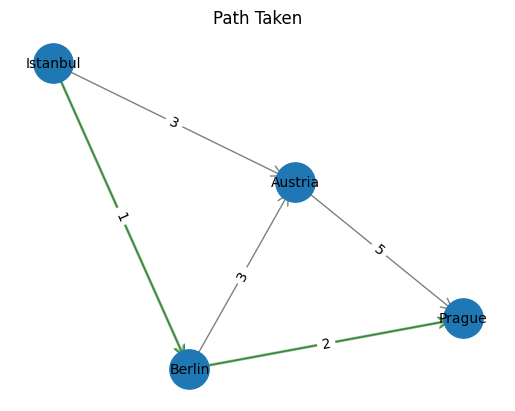

In [28]:
agent_diff = input("Choose a difficulty for me to solve: \n1. Easy\n2. Medium\n")

nodes, edges, start_node, end_node = GetNodesAndEdges(agent_diff)
    
agent = PathfinderAgent()
agent.CreateGraph(nodes, edges)

previous_nodes, shortest_path = agent.ShortestPath(start_node, end_node)
Results(agent.init_graph, nodes, previous_nodes, shortest_path, start_node=start_node, end_node=end_node) # Berlin to Prague - Medium - update graph edges

# 